# Домашнее задание 2
* В сверточной сети из примера sample_dnn_train_lecture2023 заменить свертки на depthwise-separable свертки исравнить скорость работы и результаты распознавания
* Добавить аугментацию данных и показать улучшения результатов
* Получить сеть, максимально правильно распознающую все цифры на изображении 0-9.png

### Запуск из примера обучения нейросетей

In [1]:
import cv2
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
from time import time

In [2]:
path = '/Users/Danila/temp'

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [4]:
trainset = datasets.MNIST(path, download=True, train=True, transform=transform)
testset = datasets.MNIST(path, download=True, train=False, transform=transform)

100.0%
100.0%
100.0%
100.0%


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [6]:
dataiter = iter(trainloader)
while False:
    images, labels = dataiter.next()

    cv2.imshow('image', images[0].numpy().squeeze())
    if cv2.waitKey()==27:
        cv2.destroyAllWindows()
        break;

In [7]:
input_size = 28*28
hidden_sizes = [input_size, 64]
output_size = 10
net = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                    )

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

In [9]:
images, labels = next(iter(trainloader))
res = net(images.view(-1, 28 * 28))
loss = criterion(res, labels)
print(loss)

tensor(2.3303, grad_fn=<NllLossBackward0>)


In [ ]:
time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net(images.view(-1, 28 * 28))
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =",(time()-time0)/60)

[1,   100] loss: 1.861
[1,   200] loss: 0.793
[1,   300] loss: 0.525
[1,   400] loss: 0.465
[1,   500] loss: 0.395
[1,   600] loss: 0.346
[1,   700] loss: 0.337
[1,   800] loss: 0.325
[1,   900] loss: 0.299

Training Time (in minutes) = 0.359683088461558


In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(images.shape[0], -1)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 90 %


In [12]:
x = torch.randn(64, 1, 28*28)

In [13]:
torch.onnx.export(net, x, path+'/mlp.onnx', dynamo=False)

C:\Users\Danila\AppData\Local\Temp\ipykernel_428\1658113464.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(net, x, path+'/mlp.onnx', dynamo=False)


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size= 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =",(time()-time0)/60)

[1,   100] loss: 2.291
[1,   200] loss: 2.241
[1,   300] loss: 1.692
[1,   400] loss: 0.637
[1,   500] loss: 0.363
[1,   600] loss: 0.291
[1,   700] loss: 0.244
[1,   800] loss: 0.193
[1,   900] loss: 0.180

Training Time (in minutes) = 0.4430000066757202


In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 95 %


In [18]:
x = torch.randn(64, 1, 28,28)

In [19]:
torch.onnx.export(net, x, path+'/conv1.onnx', dynamo=False)

C:\Users\Danila\AppData\Local\Temp\ipykernel_428\1450723422.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(net, x, path+'/conv1.onnx', dynamo=False)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x2 = F.relu(self.conv2(x))
        x = x + x2
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =",(time()-time0)/60)


correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))

[1,   100] loss: 2.260
[1,   200] loss: 1.709
[1,   300] loss: 0.737
[1,   400] loss: 0.446
[1,   500] loss: 0.350
[1,   600] loss: 0.291
[1,   700] loss: 0.258
[1,   800] loss: 0.218
[1,   900] loss: 0.198

Training Time (in minutes) = 0.47387604316075643
Accuracy: 94 %


In [23]:
torch.onnx.export(net, x, path+'/conv2.onnx', dynamo=False)

C:\Users\Danila\AppData\Local\Temp\ipykernel_428\558688762.py:1: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(net, x, path+'/conv2.onnx', dynamo=False)


In [24]:
model=cv2.dnn.readNetFromONNX(path+'/conv1.onnx')

In [25]:
from matplotlib import pyplot as plt

In [26]:
image = cv2.imread(path+'/0-9.png')

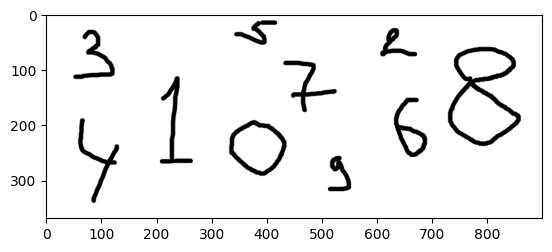

In [27]:
plt.imshow(image, cmap="gray")

In [28]:
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img.shape[:2]

In [ ]:
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255,255,0),1)
    sz2 = int(1.1*max(w,h)/2)
    xc = x + int(w/2)
    yc = y + int(h/2)
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255,0,0),1)
    img2 = img[max(0,yc-sz2):min(yc+sz2,height-1),max(0,xc-sz2):min(width-1,xc+sz2)]
    img2 = cv2.resize(img2, (28, 28))
    blob = cv2.dnn.blobFromImage(img2, 1./127, (28,28), (127,127,127), True)
    model.setInput(blob)
    outs = model.forward()
    res = np.argmax(outs)

    cv2.putText(image, str(res), (x, y),  cv2.FONT_HERSHEY_SIMPLEX,
	1.5, (50, 50, 255),1)

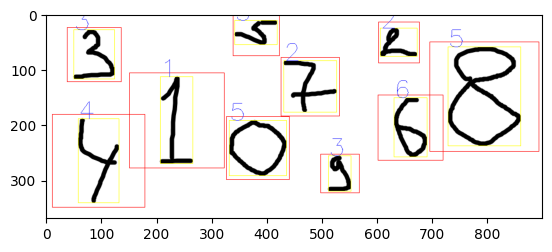

In [30]:
plt.imshow(image, cmap="gray")

# Замена сверток на depthwise-separable (с сохранением всех параметров запуска)

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=False
        )
        self.pointwise = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
            bias=False
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [35]:
class Net_Depthwise1(nn.Module):
    def __init__(self):
        super(Net_Depthwise1, self).__init__()
        self.conv1 = DepthwiseSeparableConv(in_channels=1, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = DepthwiseSeparableConv(8, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [40]:
net_dw1 = Net_Depthwise1()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_dw1.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net_dw1(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =", (time()-time0)/60)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_dw1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))
acc_dw1 = 100 * correct / total
time_dw1 = (time() - time0) / 60

[1,   100] loss: 2.303
[1,   200] loss: 2.297
[1,   300] loss: 2.288
[1,   400] loss: 2.257
[1,   500] loss: 1.805
[1,   600] loss: 0.794
[1,   700] loss: 0.506
[1,   800] loss: 0.431
[1,   900] loss: 0.378

Training Time (in minutes) = 0.4638500372568766
Accuracy: 90 %


In [41]:
class Net_Depthwise2(nn.Module):
    def __init__(self):
        super(Net_Depthwise2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = DepthwiseSeparableConv(8, 8, 3, padding=1)
        self.fc1 = nn.Linear(8 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x2 = F.relu(self.conv2(x))
        x = x + x2
        x = self.pool(x)
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
net_dw2 = Net_Depthwise2()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_dw2.parameters(), lr=0.003, momentum=0.9)

time0 = time()
epochs = 1

for e in range(epochs):
    running_loss = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        optimizer.zero_grad()
        res = net_dw2(images)
        loss = criterion(res, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        dbg_samples = 100
        if (i + 1) % dbg_samples == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e+1, i+1, running_loss / dbg_samples))
            running_loss = 0.0

print("\nTraining Time (in minutes) =", (time()-time0)/60)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_dw2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: %d %%' % (100 * correct / total))
acc_dw2 = 100 * correct / total
time_dw2 = (time() - time0) / 60

[1,   100] loss: 2.274
[1,   200] loss: 1.994
[1,   300] loss: 0.894
[1,   400] loss: 0.443
[1,   500] loss: 0.312
[1,   600] loss: 0.248
[1,   700] loss: 0.210
[1,   800] loss: 0.212
[1,   900] loss: 0.183

Training Time (in minutes) = 0.4792666713396708
Accuracy: 95 %


In [43]:
# Экспорт первой Depthwise Separable сети
x = torch.randn(64, 1, 28, 28)
torch.onnx.export(net_dw1, x, path + '/conv1_depthwise.onnx', dynamo=False)

# Экспорт второй Depthwise Separable сети
x = torch.randn(64, 1, 28, 28)
torch.onnx.export(net_dw2, x, path + '/conv2_depthwise.onnx', dynamo=False)

C:\Users\Danila\AppData\Local\Temp\ipykernel_428\223576882.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(net_dw1, x, path + '/conv1_depthwise.onnx', dynamo=False)
C:\Users\Danila\AppData\Local\Temp\ipykernel_428\223576882.py:7: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.expor

### Оценка и сравнение результатов

Модель                         Точность (%)    Время (мин)    
------------------------------------------------------------
MLP                            91.00           0.2863         
CNN1 (Original)                96.00           0.3761         
CNN2 (Residual)                96.00           0.3841         
CNN1 (Depthwise)               90.54           0.5269         
CNN2 (Depthwise+Residual)      95.24           0.5437         


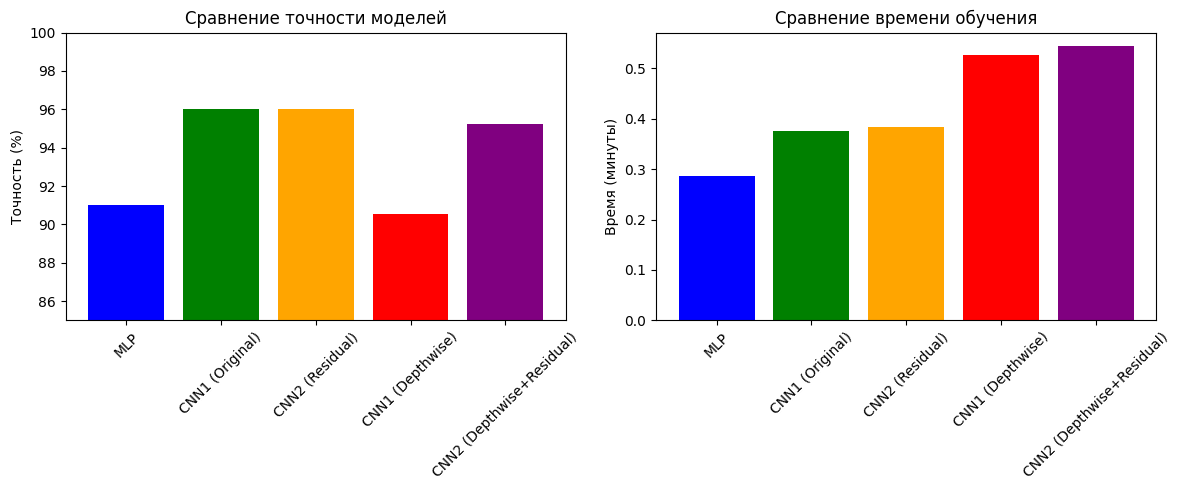

In [44]:
results = {
    'MLP': {'accuracy': 91, 'time': 0.28629990816116335},
    'CNN1 (Original)': {'accuracy': 96, 'time': 0.3760629455248515},
    'CNN2 (Residual)': {'accuracy': 96, 'time': 0.38409239451090493},
    'CNN1 (Depthwise)': {'accuracy': acc_dw1, 'time': time_dw1},
    'CNN2 (Depthwise+Residual)': {'accuracy': acc_dw2, 'time': time_dw2}
}

print(f"{'Модель':<30} {'Точность (%)':<15} {'Время (мин)':<15}")
print("-" * 60)
for model, metrics in results.items():
    print(f"{model:<30} {metrics['accuracy']:<15.2f} {metrics['time']:<15.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
models = list(results.keys())
accuracies = [results[m]['accuracy'] for m in models]
ax1.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'purple'])
ax1.set_title('Сравнение точности моделей')
ax1.set_ylabel('Точность (%)')
ax1.set_ylim(85, 100)
ax1.tick_params(axis='x', rotation=45)

times = [results[m]['time'] for m in models]
ax2.bar(models, times, color=['blue', 'green', 'orange', 'red', 'purple'])
ax2.set_title('Сравнение времени обучения')
ax2.set_ylabel('Время (минуты)')
ax2.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

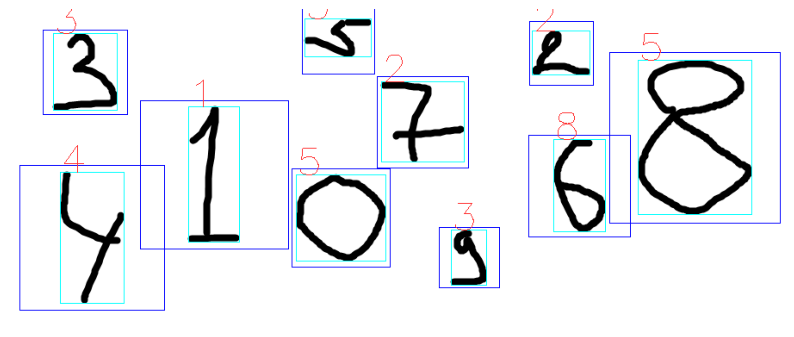

In [45]:
model_dw = cv2.dnn.readNetFromONNX(path + '/conv2_depthwise.onnx')

image = cv2.imread(path + '/0-9.png')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img_gray.shape[:2]

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255, 255, 0), 1)
    sz2 = int(1.1 * max(w, h) / 2)
    xc = x + int(w / 2)
    yc = y + int(h / 2)
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255, 0, 0), 1)
    img_roi = img_bin[max(0, yc-sz2):min(yc+sz2, height-1),
                      max(0, xc-sz2):min(width-1, xc+sz2)]
    img_roi = cv2.resize(img_roi, (28, 28))
    blob = cv2.dnn.blobFromImage(img_roi, 1./127, (28, 28), (127, 127, 127), True)
    model_dw.setInput(blob)
    outs = model_dw.forward()
    res = np.argmax(outs)

    cv2.putText(image, str(res), (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                1.5, (50, 50, 255), 1)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### Попробуем улучшить параметры моделей для большей производительности 

In [ ]:
class ImprovedDepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ImprovedDepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=False
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x

# Улучшенная версия conv1 с увеличенными каналами
class Net_Depthwise1_Improved(nn.Module):
    def __init__(self):
        super(Net_Depthwise1_Improved, self).__init__()
        # Увеличиваем каналы: 16 -> 32 -> 64 вместо 8 -> 16
        self.conv1 = ImprovedDepthwiseSeparableConv(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = ImprovedDepthwiseSeparableConv(16, 32, 3, padding=1)
        self.conv3 = ImprovedDepthwiseSeparableConv(32, 32, 3, padding=1)  # Добавляем дополнительный слой
        self.fc1 = nn.Linear(32 * 7 * 7, 256)  # Увеличиваем размерность
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Улучшенная версия conv2 с увеличенными каналами
class Net_Depthwise2_Improved(nn.Module):
    def __init__(self):
        super(Net_Depthwise2_Improved, self).__init__()
        # Увеличиваем каналы: 16 -> 32 вместо 8 -> 8
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = ImprovedDepthwiseSeparableConv(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)  # Добавляем дополнительный слой
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        residual = x
        x = self.conv2(x)
        x = x + residual  # Residual connection
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.dropout1(x)

        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
# Функция для обучения и оценки модели
def train_and_evaluate(model, model_name, epochs=3, lr=0.001):
    print(f"Обучение модели: {model_name}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_accuracies = []

    start_time = time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_batches = 0

        for batch_idx, (images, labels) in enumerate(trainloader, 0):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_batches += 1

        avg_loss = running_loss / total_batches
        train_losses.append(avg_loss)

        # Оценка на тестовых данных
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Loss: {avg_loss:.4f}, '
              f'Accuracy: {accuracy:.2f}%')

    total_time = (time() - start_time) / 60

    # Финальная оценка
    model.eval()
    final_correct = 0
    final_total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            final_total += labels.size(0)
            final_correct += (predicted == labels).sum().item()

    final_accuracy = 100 * final_correct / final_total

    # Подсчет параметров
    total_params = sum(p.numel() for p in model.parameters())

    print(f"\nРезультаты {model_name}:")
    print(f"Финальная точность: {final_accuracy:.2f}%")
    print(f"Время обучения: {total_time:.2f} минут")
    print(f"Количество параметров: {total_params:,}")

    return {
        'accuracy': final_accuracy,
        'time': total_time,
        'params': total_params,
        'train_losses': train_losses,
        'test_accuracies': test_accuracies
    }

In [52]:
# Обучаем все модели
results = {}

model_dw1_improved = Net_Depthwise1_Improved()
results['CNN1 (Depthwise Improved)'] = train_and_evaluate(model_dw1_improved, "CNN1 (Depthwise Improved)", epochs=1)

model_dw2_improved = Net_Depthwise2_Improved()
results['CNN2 (Depthwise+Res Improved)'] = train_and_evaluate(model_dw2_improved, "CNN2 (Depthwise+Res Improved)", epochs=1)

Обучение модели: CNN1 (Depthwise Improved)
Epoch 1/1: Loss: 0.2159, Accuracy: 97.50%

Результаты CNN1 (Depthwise Improved):
Финальная точность: 97.50%
Время обучения: 1.56 минут
Количество параметров: 438,117
Обучение модели: CNN2 (Depthwise+Res Improved)
Epoch 1/1: Loss: 0.2130, Accuracy: 98.28%

Результаты CNN2 (Depthwise+Res Improved):
Финальная точность: 98.28%
Время обучения: 1.21 минут
Количество параметров: 441,466


In [54]:
print(f"\n{'Модель':<40} {'Точность (%)':<15} {'Время (мин)':<12} {'Параметры':<15}")
for model_name, metrics in results.items():
    acc = metrics['accuracy']
    time_val = metrics['time']
    params = metrics['params']
    print(f"{model_name:<40} {acc:<15.2f} {time_val:<12.3f} {params:<15,}")



Модель                                   Точность (%)    Время (мин)  Параметры      
CNN1 (Depthwise Improved)                97.50           1.563        438,117        
CNN2 (Depthwise+Res Improved)            98.28           1.212        441,466        


**Путем изменения архитектуры сети смогли увеличить долю правильных ответов, но также увеличилось и время обучения**

In [55]:
x = torch.randn(64, 1, 28,28)
torch.onnx.export(model_dw1_improved, x, path+'/conv1d_imp.onnx', dynamo=False)

x = torch.randn(64, 1, 28,28)
torch.onnx.export(model_dw2_improved, x, path+'/conv2d_imp.onnx', dynamo=False)

C:\Users\Danila\AppData\Local\Temp\ipykernel_428\876924665.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model_dw1_improved, x, path+'/conv1d_imp.onnx', dynamo=False)
C:\Users\Danila\AppData\Local\Temp\ipykernel_428\876924665.py:5: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.e

In [57]:
model=cv2.dnn.readNetFromONNX(path+'/conv2d_imp.onnx')

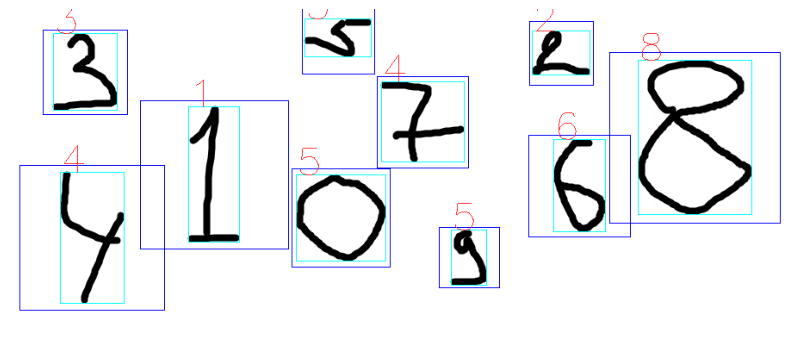

In [58]:
image = cv2.imread(path + '/0-9.png')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img_gray.shape[:2]

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255, 255, 0), 1)
    sz2 = int(1.1 * max(w, h) / 2)
    xc = x + int(w / 2)
    yc = y + int(h / 2)
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255, 0, 0), 1)
    img_roi = img_bin[max(0, yc-sz2):min(yc+sz2, height-1),
                      max(0, xc-sz2):min(width-1, xc+sz2)]
    img_roi = cv2.resize(img_roi, (28, 28))
    blob = cv2.dnn.blobFromImage(img_roi, 1./127, (28, 28), (127, 127, 127), True)
    model.setInput(blob)
    outs = model.forward()
    res = np.argmax(outs)

    cv2.putText(image, str(res), (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                1.5, (50, 50, 255), 1)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Аугментация данных

In [59]:
transform_train_augmented = transforms.Compose([
    transforms.RandomRotation(10),  # Случайный поворот на ±10 градусов
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Случайный сдвиг на 10%
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Тестовые данные без аугментации
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загружаем данные с аугментацией для обучения
path = '/Users/Danila/temp'

trainset_augmented = datasets.MNIST(path, download=True, train=True, transform=transform_train_augmented)
testset = datasets.MNIST(path, download=True, train=False, transform=transform_test)

trainloader_augmented = DataLoader(trainset_augmented, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

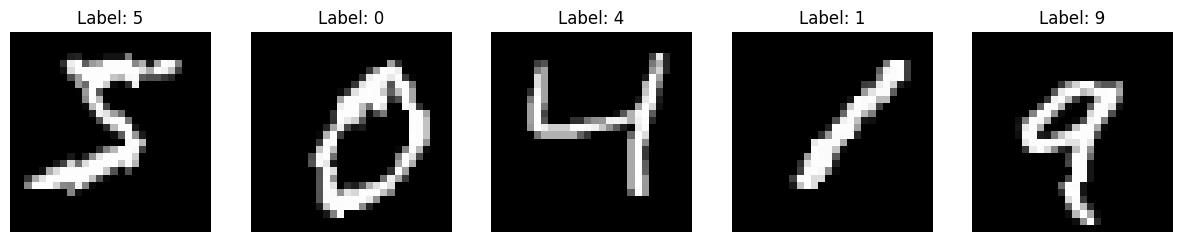

In [ ]:
# Визуализируем аугментированные данные
def show_augmented_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.numpy().squeeze()
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_augmented_images(trainset_augmented)

In [ ]:
# Улучшенная Depthwise Separable Convolution с BatchNorm
class ImprovedDepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ImprovedDepthwiseSeparableConv, self).__init__()

        self.depthwise = nn.Conv2d(
            in_channels, in_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels,
            bias=False
        )

        self.pointwise = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=1,
            bias=False
        )

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.pointwise(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x

# Архитектура с аугментацией
class Net_Depthwise_Augmented(nn.Module):
    def __init__(self):
        super(Net_Depthwise_Augmented, self).__init__()

        # Увеличим количество фильтров для компенсации емкости
        self.conv1 = ImprovedDepthwiseSeparableConv(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = ImprovedDepthwiseSeparableConv(16, 32, 3, padding=1)
        self.conv3 = ImprovedDepthwiseSeparableConv(32, 32, 3, padding=1)

        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # BatchNorm для полносвязных слоев
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.bn_fc2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)

        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(x)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)

        return x

In [ ]:
# Функция обучения с аугментацией
def train_with_augmentation(model, train_loader, test_loader, model_name, lr=0.003, epochs=1):
    print(f"Обучаем {model_name}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
    train_losses = []
    test_accuracies = []
    learning_rates = []
    start_time = time()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_batches = 0

        # Обучение с аугментацией
        for batch_idx, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            total_batches += 1

            if (batch_idx + 1) % 100 == 0:
                avg_loss = running_loss / total_batches
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(train_loader)}], '
                      f'Loss: {avg_loss:.4f}')

        avg_train_loss = running_loss / total_batches
        train_losses.append(avg_train_loss)

        # Валидация на тестовых данных
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        print(f'Epoch {epoch+1} завершен. '
              f'Loss: {avg_train_loss:.4f}, '
              f'Test Accuracy: {accuracy:.2f}%, '
              f'LR: {current_lr:.6f}')

    total_time = (time() - start_time) / 60

    # Финальная оценка
    model.eval()
    final_correct = 0
    final_total = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            final_total += labels.size(0)
            final_correct += (predicted == labels).sum().item()

    final_accuracy = 100 * final_correct / final_total

    print(f"\nФинальные результаты {model_name}:")
    print(f"Финальная точность: {final_accuracy:.2f}%")
    print(f"Время обучения: {total_time:.2f} минут")

    return model, final_accuracy, total_time, train_losses, test_accuracies, learning_rates

In [78]:
# Обучаем модель с аугментацией
model_aug = Net_Depthwise_Augmented()
model_aug, acc_aug, time_aug, losses_aug, accs_aug, lrs_aug = train_with_augmentation(
    model=model_aug,
    train_loader=trainloader_augmented,
    test_loader=testloader,
    model_name="Depthwise Separable CNN + Аугментация",
    lr=0.003,
    epochs=1
)

Обучаем Depthwise Separable CNN + Аугментация
Epoch [1/1], Batch [100/938], Loss: 0.7660
Epoch [1/1], Batch [200/938], Loss: 0.5550
Epoch [1/1], Batch [300/938], Loss: 0.4562
Epoch [1/1], Batch [400/938], Loss: 0.3973
Epoch [1/1], Batch [500/938], Loss: 0.3581
Epoch [1/1], Batch [600/938], Loss: 0.3299
Epoch [1/1], Batch [700/938], Loss: 0.3073
Epoch [1/1], Batch [800/938], Loss: 0.2886
Epoch [1/1], Batch [900/938], Loss: 0.2731
Epoch 1 завершен. Loss: 0.2679, Test Accuracy: 98.39%, LR: 0.003000

Финальные результаты Depthwise Separable CNN + Аугментация:
Финальная точность: 98.39%
Время обучения: 1.31 минут


In [73]:
# Для сравнения обучим ту же модель БЕЗ аугментации

trainset_no_aug = datasets.MNIST(path, download=False, train=True, transform=transform_test)
trainloader_no_aug = DataLoader(trainset_no_aug, batch_size=64, shuffle=True)

model_no_aug = Net_Depthwise_Augmented()
model_no_aug, acc_no_aug, time_no_aug, losses_no_aug, accs_no_aug, lrs_no_aug = train_with_augmentation(
    model=model_no_aug,
    train_loader=trainloader_no_aug,
    test_loader=testloader,
    model_name="Depthwise Separable CNN без аугментации",
    lr=0.003,
    epochs=1
)

Обучаем Depthwise Separable CNN без аугментации
Epoch [1/1], Batch [100/938], Loss: 0.4338
Epoch [1/1], Batch [200/938], Loss: 0.3234
Epoch [1/1], Batch [300/938], Loss: 0.2756
Epoch [1/1], Batch [400/938], Loss: 0.2438
Epoch [1/1], Batch [500/938], Loss: 0.2212
Epoch [1/1], Batch [600/938], Loss: 0.2065
Epoch [1/1], Batch [700/938], Loss: 0.1921
Epoch [1/1], Batch [800/938], Loss: 0.1807
Epoch [1/1], Batch [900/938], Loss: 0.1723
Epoch 1 завершен. Loss: 0.1699, Test Accuracy: 97.54%, LR: 0.003000

Финальные результаты Depthwise Separable CNN без аугментации:
Финальная точность: 97.54%
Время обучения: 1.32 минут


In [79]:
# Собираем данные из всех экспериментов
comparison_results = {
    'Depthwise (без аугментации)': {'accuracy': acc_no_aug, 'time': time_no_aug},
    'Depthwise (с аугментацией)': {'accuracy': acc_aug, 'time': time_aug},
}

print(f"\n{'Модель':<40} {'Точность (%)':<15} {'Время (мин)':<12}")

for model, metrics in comparison_results.items():
    if isinstance(metrics['accuracy'], float):
        acc_str = f"{metrics['accuracy']:.2f}"
    else:
        acc_str = f"{metrics['accuracy']}"

    time_str = f"{metrics['time']:.3f}"

    print(f"{model:<40} {acc_str:<15} {time_str:<12}")


Модель                                   Точность (%)    Время (мин) 
Depthwise (без аугментации)              97.54           1.321       
Depthwise (с аугментацией)               98.39           1.309       


In [80]:
x = torch.randn(64, 1, 28, 28)
torch.onnx.export(model_aug, x, path + '/depthwise_aug.onnx', dynamo=False)

model = cv2.dnn.readNetFromONNX(path + '/depthwise_aug.onnx')

C:\Users\Danila\AppData\Local\Temp\ipykernel_428\1933857384.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model_aug, x, path + '/depthwise_aug.onnx', dynamo=False)


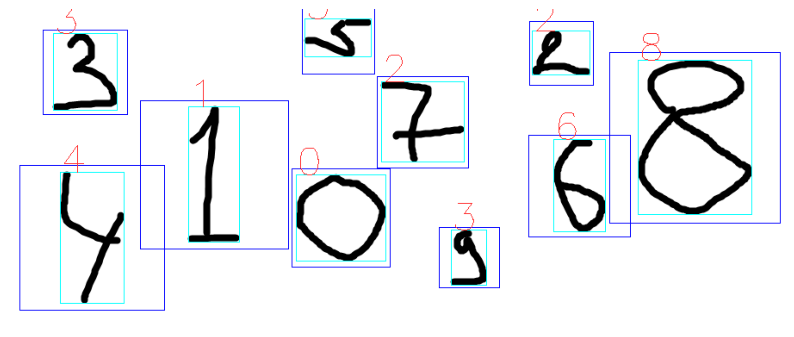

In [81]:
image = cv2.imread(path + '/0-9.png')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img_gray.shape[:2]

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255, 255, 0), 1)
    sz2 = int(1.1 * max(w, h) / 2)
    xc = x + int(w / 2)
    yc = y + int(h / 2)
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255, 0, 0), 1)
    img_roi = img_bin[max(0, yc-sz2):min(yc+sz2, height-1),
                      max(0, xc-sz2):min(width-1, xc+sz2)]
    img_roi = cv2.resize(img_roi, (28, 28))
    blob = cv2.dnn.blobFromImage(img_roi, 1./127, (28, 28), (127, 127, 127), True)
    model.setInput(blob)
    outs = model.forward()
    res = np.argmax(outs)

    cv2.putText(image, str(res), (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                1.5, (50, 50, 255), 1)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

**Взяв за основу нейронную сеть с depthwise-separable свертками с прошлого этапа, и добавив к ней аугментацию, смогли увеличить долю  правильных ответов модели при относительно таком же времени обучения. На примере распознавания рукописных цифр можно заметить прирост точности**

# Улучшенная сеть для максимально правильного распознавания всех цифр на изображении 0-9.png

In [ ]:
class FinalEnhancedNet(nn.Module):
    def __init__(self):
        super(FinalEnhancedNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.pool = nn.MaxPool2d(2, 2)

        self.conv2_depthwise = nn.Conv2d(32, 32, 3, padding=1, groups=32)
        self.conv2_pointwise = nn.Conv2d(32, 64, 1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3_depthwise = nn.Conv2d(64, 64, 3, padding=1, groups=64)
        self.conv3_pointwise = nn.Conv2d(64, 64, 1)
        self.bn3 = nn.BatchNorm2d(64)

        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        self.bn_fc1 = nn.BatchNorm1d(512)
        self.bn_fc2 = nn.BatchNorm1d(256)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.conv2_depthwise(x)
        x = self.conv2_pointwise(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv3_depthwise(x)
        x = self.conv3_pointwise(x)
        x = self.bn3(x)
        x = F.relu(x)

        x = self.dropout1(x)
        x = x.view(-1, 64 * 7 * 7)

        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)

        return x

In [87]:
# Усиленная аугментация для лучшего распознавания
transform_enhanced_augmentation = transforms.Compose([
    transforms.RandomRotation(15),  # Увеличиваем поворот до ±15 градусов
    transforms.RandomAffine(0, translate=(0.15, 0.15)),  # Увеличиваем сдвиг до 15%
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),  # Добавляем перспективные искажения
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_enhanced = datasets.MNIST(path, download=False, train=True, transform=transform_enhanced_augmentation)
trainloader_enhanced = DataLoader(trainset_enhanced, batch_size=64, shuffle=True)

In [ ]:
# Обучаем улучшенную модель
enhanced_model = FinalEnhancedNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(enhanced_model.parameters(), lr=0.001, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

train_losses = []
test_accuracies = []

start_time = time()
epochs = 5  # Увеличиваем количество эпох

for epoch in range(epochs):
    enhanced_model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(trainloader_enhanced, 0):
        optimizer.zero_grad()
        outputs = enhanced_model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(enhanced_model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 100 == 0:
            avg_loss = running_loss / (i + 1)
            print(f'[Epoch {epoch+1}, Batch {i+1}] loss: {avg_loss:.4f}')

    avg_epoch_loss = running_loss / len(trainloader_enhanced)
    train_losses.append(avg_epoch_loss)

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    enhanced_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = enhanced_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'Epoch {epoch+1} завершен. Loss: {avg_epoch_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%, LR: {current_lr:.6f}')

total_time = (time() - start_time) / 60

# Финальная точность
enhanced_model.eval()
final_correct = 0
final_total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = enhanced_model(images)
        _, predicted = torch.max(outputs.data, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

final_accuracy = 100 * final_correct / final_total
total_params = sum(p.numel() for p in enhanced_model.parameters())

print(f"\nРезультаты улучшенной модели:")
print(f"Финальная точность: {final_accuracy:.2f}%")
print(f"Время обучения: {total_time:.2f} минут")
print(f"Количество параметров: {total_params:,}")

[Epoch 1, Batch 100] loss: 1.0229
[Epoch 1, Batch 200] loss: 0.7121
[Epoch 1, Batch 300] loss: 0.5829
[Epoch 1, Batch 400] loss: 0.5099
[Epoch 1, Batch 500] loss: 0.4587
[Epoch 1, Batch 600] loss: 0.4209
[Epoch 1, Batch 700] loss: 0.3904
[Epoch 1, Batch 800] loss: 0.3664
[Epoch 1, Batch 900] loss: 0.3463
Epoch 1 завершен. Loss: 0.3392, Accuracy: 98.56%, LR: 0.001000
[Epoch 2, Batch 100] loss: 0.1793
[Epoch 2, Batch 200] loss: 0.1710
[Epoch 2, Batch 300] loss: 0.1723
[Epoch 2, Batch 400] loss: 0.1721
[Epoch 2, Batch 500] loss: 0.1692
[Epoch 2, Batch 600] loss: 0.1668
[Epoch 2, Batch 700] loss: 0.1638
[Epoch 2, Batch 800] loss: 0.1625
[Epoch 2, Batch 900] loss: 0.1609
Epoch 2 завершен. Loss: 0.1605, Accuracy: 99.04%, LR: 0.000500
[Epoch 3, Batch 100] loss: 0.1257
[Epoch 3, Batch 200] loss: 0.1240
[Epoch 3, Batch 300] loss: 0.1182
[Epoch 3, Batch 400] loss: 0.1183
[Epoch 3, Batch 500] loss: 0.1178
[Epoch 3, Batch 600] loss: 0.1156
[Epoch 3, Batch 700] loss: 0.1158
[Epoch 3, Batch 800] los

In [89]:
x = torch.randn(64, 1, 28, 28)
torch.onnx.export(enhanced_model, x, path + '/best_conv.onnx', dynamo=False)

model = cv2.dnn.readNetFromONNX(path + '/best_conv.onnx')

C:\Users\Danila\AppData\Local\Temp\ipykernel_428\2442958449.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(enhanced_model, x, path + '/best_conv.onnx', dynamo=False)


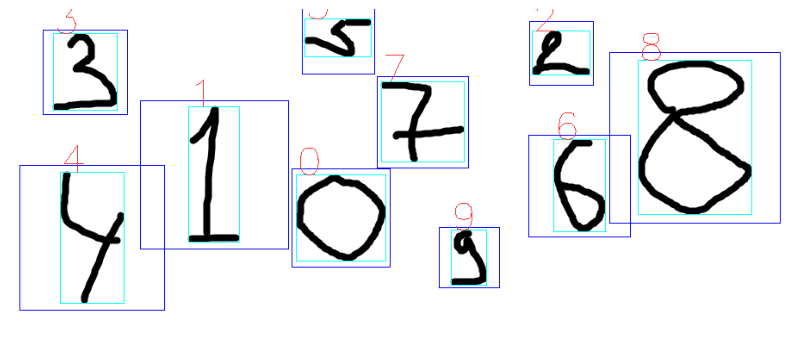

In [90]:
image = cv2.imread(path + '/0-9.png')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, img_bin = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
height, width = img_gray.shape[:2]

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x+w-1, y+h-1), (255, 255, 0), 1)
    sz2 = int(1.1 * max(w, h) / 2)
    xc = x + int(w / 2)
    yc = y + int(h / 2)
    cv2.rectangle(image, (xc-sz2, yc-sz2), (xc+sz2, yc+sz2), (255, 0, 0), 1)
    img_roi = img_bin[max(0, yc-sz2):min(yc+sz2, height-1),
                      max(0, xc-sz2):min(width-1, xc+sz2)]
    img_roi = cv2.resize(img_roi, (28, 28))
    blob = cv2.dnn.blobFromImage(img_roi, 1./127, (28, 28), (127, 127, 127), True)
    model.setInput(blob)
    outs = model.forward()
    res = np.argmax(outs)

    cv2.putText(image, str(res), (x, y), cv2.FONT_HERSHEY_SIMPLEX,
                1.5, (50, 50, 255), 1)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

**Благодаря более сложной структуре, больее длительному времени обучения, удалось получить модель с очень высокой долей правильных ответов, которая смогла идентифицировать рукописные цифры на изображении**